# Preprocesamiento y preparación del modelo

1. Carga del dataset limpio `spotify_clean.csv`.  
2. Separación de variables predictoras (X) y objetivo (`y = is_hit`).  
3. Evaluación de los modelos:  
   a. RandomForestClassifier  
   b. GradientBoostingClassifier  
   c. XGBoost  
   d. LightGBM  
   e. LogisticRegression  
   f. KNeighborsClassifier  
4. Escalado o normalización de variables numéricas.  
5. División del conjunto en entrenamiento y prueba (`train_test_split`).  
6. Guardado de los datos procesados (`X_train`, `X_test`, `y_train`, `y_test`).  


In [4]:


import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import os
import joblib
import numpy as np

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression


import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
import seaborn as sns

# Ruta al archivo fuente inicial 
DATA_PATH = "../data/processed/spotify_clean.csv"

# Verificar existencia
if not os.path.exists(DATA_PATH):
    raise FileNotFoundError(f"No se encontró el archivo en {DATA_PATH}")

# Carga el archivo CSV
df = pd.read_csv(DATA_PATH)
print(f"Dataset se ha cargado correctamente en un arreglo: {df.shape}")

display(df.columns.T)
display(df.head())


Dataset se ha cargado correctamente en un arreglo: (232724, 15)


Index(['genre', 'popularity', 'acousticness', 'danceability', 'duration_ms',
       'energy', 'instrumentalness', 'liveness', 'loudness', 'mode',
       'speechiness', 'tempo', 'time_signature', 'valence', 'is_hit'],
      dtype='object')

,genre,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,mode,speechiness,tempo,time_signature,valence,is_hit
0,Movie,0,0.611,0.389,99373,0.910,0.000,0.3460,-1.828,1,0.0525,166.969,4,0.814,0
1,Movie,1,0.246,0.590,137373,0.737,0.000,0.1510,-5.559,0,0.0868,174.003,4,0.816,0
2,Movie,3,0.952,0.663,170267,0.131,0.000,0.1030,-13.879,0,0.0362,99.488,5,0.368,0
3,Movie,0,0.703,0.240,152427,0.326,0.000,0.0985,-12.178,1,0.0395,171.758,4,0.227,0
4,Movie,4,0.950,0.331,82625,0.225,0.123,0.2020,-21.150,1,0.0456,140.576,4,0.390,0


## Normalizacion duration_ms

In [5]:
## Normalizacion Duracion
df["duration_min"] = df["duration_ms"] / 60000
df.drop(columns="duration_ms", inplace=True)


## Separación de variables predictoras (X) y objetivo (y)


In [6]:

X = df.drop(columns=["is_hit","popularity"])
y = df["is_hit"]


## Creación de DataFrames para Codificar Variabls Categóricas y Entrenamiento de Modelos 


In [7]:
# Para modelos de árboles → LabelEncoder
X_tree = X.copy()
le = LabelEncoder()
X_tree["genre"] = le.fit_transform(X_tree["genre"])

# Para modelos lineales / distancia → OneHotEncoder
preprocessor_ohe = ColumnTransformer([
    ("cat", OneHotEncoder(handle_unknown="ignore"), ["genre"])
], remainder="passthrough")

In [8]:
display(X_tree.dtypes)

X_tree.describe()




genre                 int64
acousticness        float64
danceability        float64
energy              float64
instrumentalness    float64
liveness            float64
loudness            float64
mode                  int64
speechiness         float64
tempo               float64
time_signature        int64
valence             float64
duration_min        float64
dtype: object

,genre,acousticness,danceability,energy,instrumentalness,liveness,loudness,mode,speechiness,tempo,time_signature,valence,duration_min
count,232724.000000,232724.000000,232724.000000,232724.000000,232724.000000,232724.000000,232724.000000,232724.000000,232724.000000,232724.000000,232724.000000,232724.000000,232724.000000
mean,13.623270,0.368562,0.554366,0.570958,0.148302,0.215010,-9.569896,0.652030,0.120765,117.666494,3.885147,0.454919,3.918697
std,7.491218,0.354768,0.185608,0.263456,0.302769,0.198273,5.998215,0.476328,0.185519,30.898942,0.462956,0.260065,1.982265
min,0.000000,0.000000,0.056900,0.000020,0.000000,0.009670,-52.457000,0.000000,0.022200,30.379000,0.000000,0.000000,0.256450
25%,7.000000,0.037600,0.435000,0.385000,0.000000,0.097400,-11.771000,0.000000,0.036700,92.959000,4.000000,0.237000,3.047604
50%,14.000000,0.232000,0.571000,0.605000,0.000044,0.128000,-7.762000,1.000000,0.050100,115.777500,4.000000,0.444000,3.673783
75%,20.000000,0.722000,0.692000,0.787000,0.035800,0.264000,-5.501000,1.000000,0.105000,139.054500,4.000000,0.660000,4.429467
max,26.000000,0.996000,0.989000,0.999000,0.999000,1.000000,3.744000,1.000000,0.967000,242.903000,5.000000,1.000000,92.548617


## Division de datos

### División en entrenamiento y prueba


In [9]:
X_train_tree, X_test_tree, y_train, y_test = train_test_split(X_tree, y, test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



In [10]:
X_train_tree.describe().T


,count,mean,std,min,25%,50%,75%,max
genre,186179.0,13.617218,7.486709,0.000000,7.000000,14.000000,20.00000,26.000000
acousticness,186179.0,0.368902,0.354867,0.000001,0.037600,0.233000,0.72200,0.996000
danceability,186179.0,0.554477,0.185612,0.056900,0.435000,0.571000,0.69200,0.989000
energy,186179.0,0.570743,0.263453,0.000020,0.385000,0.605000,0.78700,0.999000
instrumentalness,186179.0,0.148567,0.303068,0.000000,0.000000,0.000045,0.03590,0.999000
liveness,186179.0,0.215131,0.198184,0.009670,0.097400,0.128000,0.26400,1.000000
loudness,186179.0,-9.572569,5.999228,-52.457000,-11.779000,-7.762000,-5.50200,3.744000
mode,186179.0,0.651701,0.476433,0.000000,0.000000,1.000000,1.00000,1.000000
speechiness,186179.0,0.120547,0.185210,0.022200,0.036700,0.050100,0.10500,0.967000
tempo,186179.0,117.667631,30.906681,30.379000,92.938000,115.836000,139.09000,242.903000


In [11]:
X_train_tree["genre"].unique()[:10]


array([25,  9,  6,  8, 14, 23, 17, 22, 24,  4])

## Definicion de Modelos

In [12]:
# # Definir coleccion de salida
# resultados = []

# pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])

# # Modelos tipo árbol
# tree_models = {
#     "RandomForest": RandomForestClassifier(n_jobs=-1, random_state=42, class_weight="balanced"),
#     "GradientBoosting": GradientBoostingClassifier(random_state=42), 
#     "XGBoost": XGBClassifier(n_jobs=-1, eval_metric="logloss", random_state=42, scale_pos_weight=pos_weight),
#     "LightGBM": LGBMClassifier(n_jobs=-1,random_state=42,class_weight='balanced', num_leaves=64, n_estimators=500, learning_rate=0.05)

# }

# for nombre, modelo in tree_models.items():
#     modelo.fit(X_train_tree, y_train)
#     y_pred = modelo.predict(X_test_tree)
#     resultados.append({
#         "Modelo": nombre,
#         "Accuracy": accuracy_score(y_test, y_pred),
#         "F1": f1_score(y_test, y_pred),
#         "ROC_AUC": roc_auc_score(y_test, y_pred)
#     })

# # Modelos lineales / distancia
# linear_models = {
#     "LogisticRegression": LogisticRegression(max_iter=1000, n_jobs=-1,class_weight="balanced"),
#     "KNeighbors": KNeighborsClassifier(n_jobs=-1)
# }

# for nombre, modelo in linear_models.items():
#     # Usa pipeline con OneHotEncoder
#     clf = Pipeline(steps=[
#         ("preprocess", preprocessor_ohe),
#         ("model", modelo)
#     ])
#     clf.fit(X_train, y_train)
#     y_pred = clf.predict(X_test)
#     resultados.append({
#         "Modelo": nombre,
#         "Accuracy": accuracy_score(y_test, y_pred),
#         "F1": f1_score(y_test, y_pred),
#         "ROC_AUC": roc_auc_score(y_test, y_pred)
#     })

# # Tabla final
# df_resultados = pd.DataFrame(resultados).sort_values(by="F1", ascending=False)
# display(df_resultados)


In [13]:
# ===============================
# CONFIGURACIÓN GENERAL
# ===============================

# Calcular peso de clase positiva (para XGBoost)
pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])

# Colección para guardar resultados de todos los experimentos
resultados_globales = []

# ===============================
# DEFINIR BATCHES DE EXPERIMENTOS
# ===============================

batch_1 = {
    "RandomForest": {"n_estimators": 300, "max_depth": None, "min_samples_leaf": 2},
    "GradientBoosting": {"n_estimators": 400, "learning_rate": 0.05, "max_depth": 5},
    "XGBoost": {"n_estimators": 600, "learning_rate": 0.05, "max_depth": 6},
    "LightGBM": {"n_estimators": 600, "num_leaves": 64, "learning_rate": 0.03},
    "LogisticRegression": {"max_iter": 1000, "solver": "liblinear"},
    "KNeighbors": {"n_neighbors": 10, "weights": "distance"}
}

batch_2 = {
    "RandomForest": {"n_estimators": 800, "max_depth": 10, "min_samples_leaf": 1},
    "GradientBoosting": {"n_estimators": 800, "learning_rate": 0.02, "max_depth": 6},
    "XGBoost": {"n_estimators": 1000, "learning_rate": 0.03, "max_depth": 8},
    "LightGBM": {"n_estimators": 1000, "num_leaves": 128, "learning_rate": 0.02},
    "LogisticRegression": {"max_iter": 2000, "solver": "liblinear"},
    "KNeighbors": {"n_neighbors": 20, "weights": "uniform"}
}

# Puedes agregar batch_3, batch_4, etc.
batches = {"Batch_1": batch_1, "Batch_2": batch_2}

# ===============================
# FUNCIÓN PARA EJECUTAR UN BATCH
# ===============================

def entrenar_batch(nombre_batch, config_batch):
    resultados = []

    # Modelos tipo árbol
    tree_models = {
        "RandomForest": RandomForestClassifier(n_jobs=-1, random_state=42, class_weight="balanced", **config_batch["RandomForest"]),
        "GradientBoosting": GradientBoostingClassifier(random_state=42, **config_batch["GradientBoosting"]),
        "XGBoost": XGBClassifier(
            n_jobs=-1,
            eval_metric="logloss",
            random_state=42,
            scale_pos_weight=pos_weight,
            **config_batch["XGBoost"]
        ),
        "LightGBM": LGBMClassifier(
            n_jobs=-1,
            random_state=42,
            class_weight="balanced",
            **config_batch["LightGBM"]
        )
    }

    for nombre, modelo in tree_models.items():
        modelo.fit(X_train_tree, y_train)
        y_pred = modelo.predict(X_test_tree)
        resultados.append({
            "Batch": nombre_batch,
            "Modelo": nombre,
            "Accuracy": accuracy_score(y_test, y_pred),
            "F1": f1_score(y_test, y_pred),
            "ROC_AUC": roc_auc_score(y_test, y_pred)
        })

    # Modelos lineales / distancia
    linear_models = {
        "LogisticRegression": LogisticRegression(class_weight="balanced", **config_batch["LogisticRegression"]),
        "KNeighbors": KNeighborsClassifier(n_jobs=-1, **config_batch["KNeighbors"])
    }

    for nombre, modelo in linear_models.items():
        clf = Pipeline(steps=[
            ("preprocess", preprocessor_ohe),
            ("model", modelo)
        ])
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        resultados.append({
            "Batch": nombre_batch,
            "Modelo": nombre,
            "Accuracy": accuracy_score(y_test, y_pred),
            "F1": f1_score(y_test, y_pred),
            "ROC_AUC": roc_auc_score(y_test, y_pred)
        })

    return resultados

# ===============================
# EJECUTAR TODOS LOS BATCHES
# ===============================

for nombre_batch, config in batches.items():
    resultados_globales.extend(entrenar_batch(nombre_batch, config))

# ===============================
# RESULTADOS COMBINADOS
# ===============================

df_resultados = pd.DataFrame(resultados_globales).sort_values(by=["Batch", "F1"], ascending=[True, False])
display(df_resultados)


[LightGBM] [Info] Number of positive: 8357, number of negative: 177822
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018228 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2582
[LightGBM] [Info] Number of data points in the train set: 186179, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Info] Number of positive: 8357, number of negative: 177822
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017976 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2582
[LightGBM] [Info] Number of data points in the train set: 186179, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


,Batch,Modelo,Accuracy,F1,ROC_AUC
3,Batch_1,LightGBM,0.863422,0.374249,0.866182
2,Batch_1,XGBoost,0.853733,0.358341,0.861098
0,Batch_1,RandomForest,0.960576,0.322628,0.598950
4,Batch_1,LogisticRegression,0.777957,0.264570,0.812213
1,Batch_1,GradientBoosting,0.955377,0.124737,0.533408
5,Batch_1,KNeighbors,0.951488,0.120031,0.532672
9,Batch_2,LightGBM,0.923988,0.513610,0.890785
8,Batch_2,XGBoost,0.917585,0.492995,0.886774
10,Batch_2,LogisticRegression,0.777957,0.264570,0.812213
6,Batch_2,RandomForest,0.754625,0.244793,0.798233


In [14]:
display(df_resultados.T)

,3,2,0,4,1,5,9,8,10,6,7,11
Batch,Batch_1,Batch_1,Batch_1,Batch_1,Batch_1,Batch_1,Batch_2,Batch_2,Batch_2,Batch_2,Batch_2,Batch_2
Modelo,LightGBM,XGBoost,RandomForest,LogisticRegression,GradientBoosting,KNeighbors,LightGBM,XGBoost,LogisticRegression,RandomForest,GradientBoosting,KNeighbors
Accuracy,0.863422,0.853733,0.960576,0.777957,0.955377,0.951488,0.923988,0.917585,0.777957,0.754625,0.955484,0.952605
F1,0.374249,0.358341,0.322628,0.26457,0.124737,0.120031,0.51361,0.492995,0.26457,0.244793,0.139535,0.041703
ROC_AUC,0.866182,0.861098,0.59895,0.812213,0.533408,0.532672,0.890785,0.886774,0.812213,0.798233,0.537811,0.510219


In [ ]:
df_pivot = (
    df_resultados
    .pivot(index="Modelo", columns="Batch", values=["Accuracy", "F1", "ROC_AUC"])
    .sort_index(axis=1, level=0)  # agrupa métricas juntas
)
# Metric → Batch_1 | Batch_2
df_pivot.columns = [f"{metric}_{batch}" for metric, batch in df_pivot.columns]

display(df_pivot)


,Accuracy_Batch_1,Accuracy_Batch_2,F1_Batch_1,F1_Batch_2,ROC_AUC_Batch_1,ROC_AUC_Batch_2
Modelo,,,,,,
GradientBoosting,0.955377,0.955484,0.124737,0.139535,0.533408,0.537811
KNeighbors,0.951488,0.952605,0.120031,0.041703,0.532672,0.510219
LightGBM,0.863422,0.923988,0.374249,0.513610,0.866182,0.890785
LogisticRegression,0.777957,0.777957,0.264570,0.264570,0.812213,0.812213
RandomForest,0.960576,0.754625,0.322628,0.244793,0.598950,0.798233
XGBoost,0.853733,0.917585,0.358341,0.492995,0.861098,0.886774


## Visualizacion de resultados.

In [15]:
# df_resultados.plot(x="Modelo", y=["Accuracy", "F1", "ROC_AUC"], kind="bar", figsize=(10,5))
# plt.title("Comparación de modelos - Predicción de 'Hit'")
# plt.ylabel("Puntaje")
# plt.ylim(0,1)
# plt.grid(True)
# plt.show()

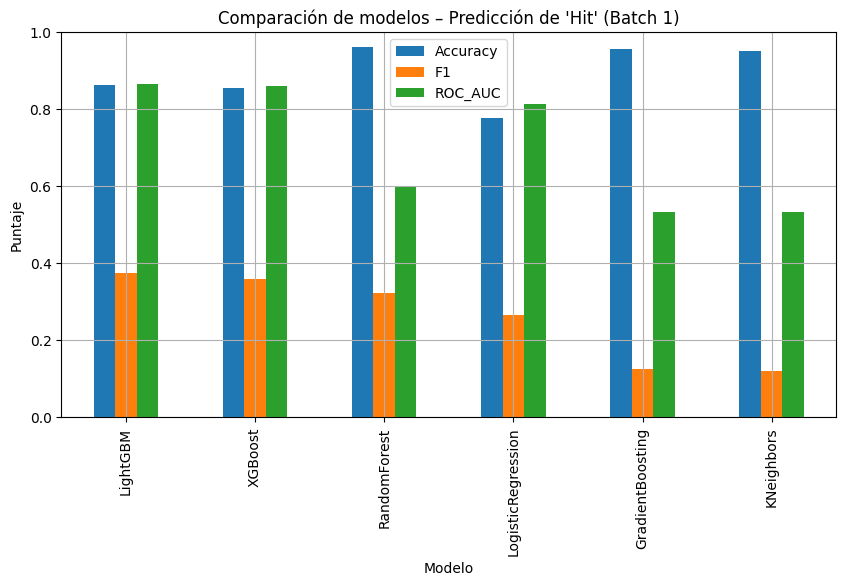

In [16]:
df_batch1 = df_resultados[df_resultados["Batch"] == "Batch_1"]

df_batch1.plot(
    x="Modelo",
    y=["Accuracy", "F1", "ROC_AUC"],
    kind="bar",
    figsize=(10,5)
)

plt.title("Comparación de modelos – Predicción de 'Hit' (Batch 1)")
plt.ylabel("Puntaje")
plt.ylim(0,1)
plt.grid(True)
plt.show()

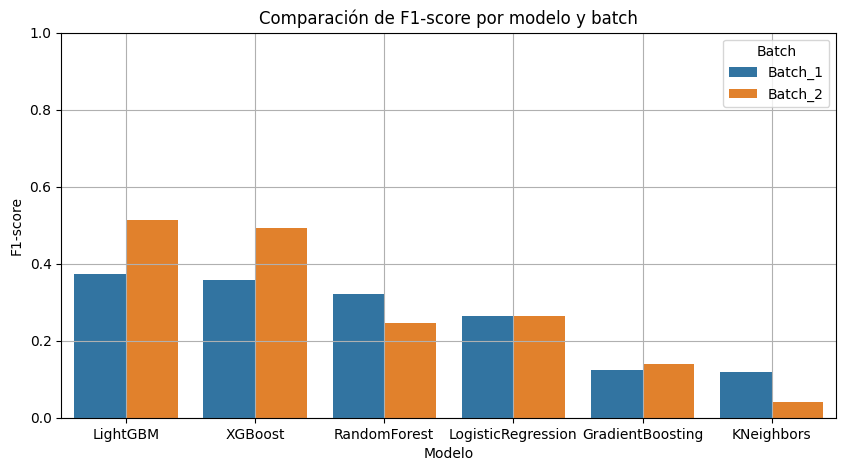

In [17]:
import seaborn as sns

plt.figure(figsize=(10,5))
sns.barplot(data=df_resultados, x="Modelo", y="F1", hue="Batch")
plt.title("Comparación de F1-score por modelo y batch")
plt.ylabel("F1-score")
plt.ylim(0,1)
plt.grid(True)
plt.show()


## Guardado de los datos procesados
